# Trade Size Distributions and Befords Law

In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
cwd = os.getcwd()
#List of csv collections
collectionCSVs = [
    "0n1_force.csv",
    "axie_infinity.csv",
    "azuki.csv",
    "bored_ape.csv",
    "clone_x.csv",
    "coolmonkes.csv",
    "creature_world.csv",
    "creepz_reptile.csv",
    "creeps.csv",
    "cryptoadz.csv",
    "cryptobatz.csv",
    "cryptokitties.csv",
    "cryptopunks.csv",
    "cryptoskulls.csv",
    "cyberkongz_vx.csv",
    "DeadFellaz.csv",
    "decentraland_wearables.csv",
    "doge_pound.csv",
    "doodles.csv",
    "dr_ETHvil.csv",
    "emblem_vaul.csv",
    "FLUF_world_thingies.csv",
    "fomo_mofos.csv",
    "full_send.csv",
    "hape_prime.csv",
    "hashmasks.csv",
    "lil_heroes.csv",
    "lostpoets.csv",
    "meebits.csv",
    "mekaverse.csv",
    "metroverse.csv",
    "mutant_ape.csv",
    "my_curio_cards.csv",
    "phantabear.csv",
    "pudgypenguins.csv",
    "punkcomics.csv",
    "rarible.csv",
    "rtfkt.csv",
    "sorare.csv",
    "superrare.csv",
    "wolf_game.csv",
    "world of women.csv",
    "wvrps.csv",
    "x_rabbits.csv"
]

In [7]:
def first_sig_fig(number):
    """Returns the first significant digit of a provided number as string
    
    Parameters
    ----------
    number: The number whose first significant digit will be returned
    
    Raises
    ------
    TypeError: If the provided variable is not a number a TypeError will be raised
    """
    #Check that what is provided is actually a number
    if type(number) != int and type(number) != float and isinstance(number, numpy) == False:
        raise TypeError(f"{number} is not a number, it is of type {type(number)}")
    #Turn number into string so that it's iterable
    snumber = str(number)
    #Sentinel value to determine if we've hit the decimals yet.
    decimal_encountered = False
    for i in range(0,len(snumber)):
        if snumber[i].isdigit():
            temp = snumber[i]
            if snumber[i] == '0':
                pass
            else:
                return snumber[i]
        else:
            pass

In [8]:
def benford(array):
    """Takes in an array of prices as int or float and returns 
    the distribution of the first significant digit as a dict of each 
    digit and the respective count.
    
    Parameters
    ----------
    array: The numpy array to work with
    """
    c1, c2, c3, c4, c5, c6, c7, c8, c9 = 0, 0, 0, 0, 0, 0, 0, 0, 0
    for value in array:
        if first_sig_fig(value) == '1':
            c1 += 1
        elif first_sig_fig(value) == '2':
            c2 += 1
        elif first_sig_fig(value) == '3':
            c3 += 1
        elif first_sig_fig(value) == '4':
            c4 += 1
        elif first_sig_fig(value) == '5':
            c5 += 1
        elif first_sig_fig(value) == '6':
            c6 += 1
        elif first_sig_fig(value) == '7':
            c7 += 1
        elif first_sig_fig(value) == '8':
            c8 += 1
        elif first_sig_fig(value) == '9':
            c9 += 1
        else:
            raise Exception(f"First sig fig is not a number 1-9")
    counts = {'1':c1, '2':c2, '3':c3, '4':c4, '5':c5, '6':c6, '7':c7, '8':c8, '9':c9}
    return counts

In [9]:
def clean_panda(dataframe):
    """Takes in a Panda dataframe read from an opensea csv, drops bad rows, 
    bundle data, non ETH transactions then deletes original panda from memory.
    
    Params
    ------
    panda - The panda to take in
    
    Returns
    -------
    cleaned_dataframe - The cleaned dataframe"""
    
    def main(dataframe):
        dataframe = drop_bad_rows(dataframe)
        dataframe = drop_bundle(dataframe)
        dataframe = drop_nETH(dataframe)
        dataframe.reset_index(inplace=True, drop=True)
        return dataframe
    
    def drop_bad_rows(dataframe):
        ret = dataframe.dropna(subset=['total_price'])
        return ret
    
    def drop_bundle(dataframe):
        return dataframe.iloc[:, 1:150]
    
    def drop_nETH(dataframe):
        #What happens if there are no non ETH indices?
        bad_indices = dataframe[(dataframe.payment_token_id != 1) & (dataframe.payment_token_id != 2)].index
        ret = dataframe.drop(bad_indices)
        return ret
    
    return main(dataframe)

In [55]:
def make_adjprice(dataframe):
        #Make an adj_price column to represent ETH price
        adj_price = dataframe.apply(lambda row: float(row.total_price) / (10**row.payment_token_decimals), axis = 1)
        return adj_price

In [84]:
def roundness_check(adj_prices):
    def last_sig_fig(number):
        """Returns an integer indicating how many places after the decimal the last significant digit is. 1 returned is considered to be 
        the tenths place, while -1 would indicate the ones place
        
        Params
        ------
        number - the number to find the last sigfig of
        
        Returns
        -------
        The integer representation of the last sigfig's place"""
        
        if type(number) != float and type(number) != int:
            raise ValueError(f'{number} is neither a float or int')
        
        #Convert to string to use indexing
        strnum = str(number)
        
        def calc_ones(strnum):
            last_sig_index = -9999
            #Strip decimal if we have one
            if '.' in strnum:
                strnum = strnum[0:strnum.rfind('.')]
            #Get length -1 for range
            length = len(strnum)
            for i in range(0, length):
                if strnum[i] != '0':
                    last_sig_index = i
            if last_sig_index != -9999:
                return -(len(strnum) - last_sig_index)
            else:
                #Edge case where we're processing 0.0
                return -1
            
        #0 and 1 can both be confused in boolean expressions, uses a decided 'null' value instead.
        last_sig_index = -9999
        if '.' in strnum:
            #rfinds gets the index of last .
            dec_loc = strnum.rfind('.')
            for i in range(dec_loc+1, (len(strnum))):
                #Zeros after the . will never be the last sigfig
                if strnum[i]!='0':
                    last_sig_index = i
            #We found sigfig past decimal
            if last_sig_index != -9999:
                #Return the last occurence, but first calculate the place:
                return last_sig_index-dec_loc
        #If there isnt a decimal, or we didn't find a sigfig past
        return calc_ones(strnum)
    
    counts = np.empty(0)
    for adj_price in adj_prices:
        #Find the last significant digit
        place = last_sig_fig(adj_price)
        counts = np.append(counts, place)
        """if (place < -4) | (place > 5) | (place == 0):
            raise Exception(f'Sigfig was: {place} and adj_price = {adj_price}' +
                            '. Considered outside of the realized bounds, and therefore has not been accounted for')"""
        """#Then increment the list
        if place == -4:
            thousands = thousands+1
        elif place == -3:
            hundreds = hundreds+1
        elif place == -2:
            tens = tens + 1
        elif place == -1:
            ones = ones + 1
        elif place == 1:
            tenths = tenths + 1
        elif place == 2:
            hundreths = hundreths + 1
        elif place == 3:
            thousandths = thousandths + 1
        elif place == 4:
            ten_thousandths = ten_thousandths + 1
        elif place == 5:
            hundred_thousandths = hundred_thousandths + 1
            
    return {'hundred_thousandths':hundred_thousandths, 'ten_thousandths':ten_thousandths, 'hundreths': hundreths, 'tenths': tenths, 
           'ones':ones, 'tens':tens, 'hundreds':hundreds, 'thousands':thousands}"""
    number, occurrences = np.unique(counts, return_counts=True)
    returndict = {}
    j = 0
    for i in number:
        returndict[f'{i}']=occurrences[j]
        j = j + 1
    return returndict

In [83]:
def prep_pie(np_counts):
    labels = []
    counts = []
    for i in test:
        labels.append(i)
        counts.append(test[i])
    return labels, counts

In [82]:
def make_first_sig(adj_price):
    series = []
    for i in adj_price:
        series.append(first_sig_fig(i))
    return series

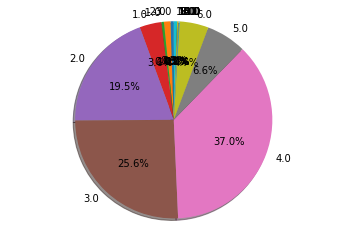

In [72]:
fig1, ax1 = plt.subplots()
ax1.pie(counts, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

For chi squared test after this there is an 'expected value' that we need, need to look into how to calculate that value.

In [12]:
#Load in another panda
fomo_location = cwd + "/data/fomo_mofos.csv"
fomo = pd.read_csv(fomo_location, low_memory=False)

In [13]:
fomo = clean_panda(fomo)
fomo['adj_price'] = make_adjprice(fomo)

In [14]:
fomo['adj_price'].describe()

count    11285.000000
mean         0.583211
std          0.538061
min          0.000000
25%          0.420000
50%          0.489000
75%          0.650000
max         20.000000
Name: adj_price, dtype: float64

## Check for roundness

In [89]:
a = roundness_check(fomo['adj_price'])

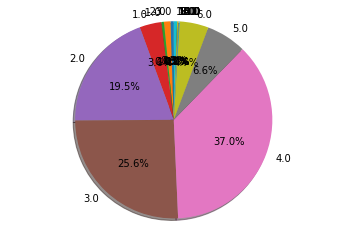

In [92]:
labels, counts = prep_pie(a)
fig1, ax1 = plt.subplots()
ax1.pie(counts, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Making the first sig key for the panda

In [47]:
first_sig = make_first_sig(fomo['adj_price'])


In [48]:
fomo['eth_first_sig'] = first_sig

## First Significant Digit in ETH

In [49]:
fomo_first_counts = fomo['first_sig'].value_counts()

<AxesSubplot:>

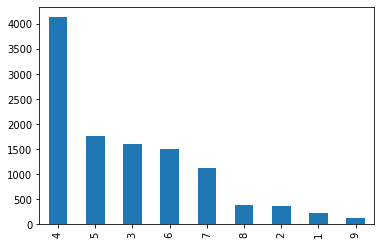

In [50]:
fomo_first_counts.plot(kind='bar')

## First Significant Digit in USD converted from ETH

In [40]:
def make_usdprice(adj_price, payment_token_eth_price):
    series = []
    for i, j in zip(adj_price, payment_token_eth_price):
        series.append(i*j)
    return series

In [45]:
fomo['usd_price'] = make_usdprice(fomo['adj_price'], fomo['payment_token_usd_price'])

0    1074.3040
1    1074.3040
2     980.3024
3    1074.3040
4    1074.3040
Name: usd_price, dtype: float64

In [51]:
fomo['usd_first_sig'] = make_first_sig(fomo['usd_price'])

<AxesSubplot:>

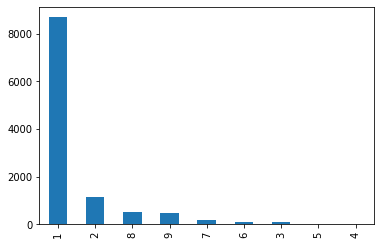

In [54]:
fomo['usd_first_sig'].value_counts().plot(kind='bar')

In [85]:
fomo['usd_first_sig'].value_counts()

1    8683
2    1155
8     510
9     480
7     184
6     104
3     100
5      36
4      32
Name: usd_first_sig, dtype: int64

### This plot follows Benfords Law a little better, but highly affected by clustering 

## Tail Distribution

In [65]:
#What is the appropriate data to be thrown into powerlaw? Counts of the values and their frequency?
#By percentage? Looking into this
fit = powerlaw.Fit(fomo['usd_price'].value_counts())

Calculating best minimal value for power law fit


In [66]:
fit.power_law.alpha

1.794262254097783

In [67]:
fit.power_law.sigma

0.034116485077311624

In [68]:
fit.distribution_compare('power_law', 'exponential')

(377.39811815360446, 2.4656191507292515e-18)

In [75]:
fomo_value_counts = fomo['usd_price'].value_counts()

## Trade Clustering